# Stability optimization

Show some stability optimization approaches described in https://jmlr.org/papers/volume22/20-366/20-366.pdf.

The following analysis can be adapted and revised accordingly. Ideally, we would use the same dataset (currently tomato dataset) in all notebooks. Here, we continue to work on the tasks from the feature slection notebook.

______________________________

In this tutorial, we will explore the concept of _'stability'_ of a feature selection algorithm. The term here refers to the robustness of its feature preferences, with respect to data sampling.  We can say that feature has high stability if multiple feature selection repetitions “agree” that this feature is important and low stability when multiple feature selection processes  “disagree” that this feature is important.  

Stability is not always easy to achieve, especially in the real world data, but it is extremely important to analyse when selecting features. Having a stable set of features is a proxy for _reproducible research_, especially in the biomedical field (e.g. which genes that algorithm selected are likely to be a data artefact and not a real clinical signal worth pursuing further?)

This tutorial is based on the following paper and the code the authors provide:

[1] [Nogueira, Sarah, Konstantinos Sechidis, and Gavin Brown. "On the stability of feature selection algorithms." The Journal of Machine Learning Research 18.1 (2017): 6345-6398.](https://www.jmlr.org/papers/volume18/17-514/17-514.pdf)


______________________________

As always, we first load the packages we need:

In [6]:
import sys
sys.path.append("..")

import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics._scorer import make_scorer
from sklearn.metrics import balanced_accuracy_score, accuracy_score
from helpers import getBootstrapSample
from helpers import stability as st
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import Counter

## Data loading

Here we just load the data we preprocessed in the data_preprocessing.ipynb. Recall, this is the gene expression dataset with... **TBA**


[**NOTE** - currently the results show the breast cancer dataset as they are much better to showcase what we want!]

In [5]:
#data = pd.read_csv("./data/tomatos_with_targets.txt", index_col=0)
data = pd.read_csv("./data/breast_cancer.csv")
data.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


Inspecing the target:

In [7]:
Counter(data['target'])

Counter({1: 357, 0: 212})

## Setup

**Note: Adjust here or remove the code not needed (depends which dataset you choose)**

If tomato dataset: 
We extracted multiple targets from the dataset and here we want to choose which one we decide to model and we discard the rest.

In [9]:
# Choose the target
#target = 'species' # If tomato dataset
target = 'target' # If bc dataset

# Targets
#potential_targets = ['species','position','tissue','root'] # If tomato dataset
potential_targets = [] # Uncomment this line here if you are using breast cancer DS, there is only 1 target 
# Remove other potential targets
drop = list(set(potential_targets) - set([target]))
data_model = data.drop(columns = drop, axis = 1)
data_model.head()

# Save only feature column names:
feature_columns =  data_model.drop(columns=[target], axis=1).columns

# Save X and y separately
X = data_model.drop(target, axis=1)
y = data_model[target]

If tomato dataset:
Encode the labels: our labels are categorical and we need to encode them to have integer values. 

Scale the data: Regression models benefit from scaling the data.

In [12]:
# Uncomment if tomato dataset:

# Encode labels if it is classification
# encoder = LabelEncoder() 
# y = encoder.fit_transform(y)

print(np.unique(data_model[target], return_counts=True))
print(np.unique(y, return_counts=True))
#Scale the data --> Note: decide if you do this here or in each separate run (sample) below. 
scaler = StandardScaler()
X_transformed = scaler.fit_transform(X)

(array([0, 1]), array([212, 357]))
(array([0, 1]), array([212, 357]))


In [32]:
X_transformed[:5,:5]

array([[ 0.81415875, -0.35024209, -0.20851441, -0.27482876,  0.        ],
       [-1.03764141,  3.68690371, -0.20851441,  1.72916449,  0.        ],
       [-1.03764141, -0.35024209, -0.20851441, -1.2944904 ,  0.        ],
       [ 1.835353  , -0.35024209, -0.20851441,  1.28724006,  0.        ],
       [-1.03764141, -0.35024209, -0.20851441,  0.01203308,  0.        ]])

## Modeling without taking stability into account
Regularization strength is a hyperparameter passed to LogisticRegression model (part of sklearn). As usual, when we are tuning the hyperparameters, we are trying to find the set for which the model accuracy is maximized, i.e., error is minimized.

E.g. in the case of regularized regression, if we are tuning the regularization strength (parameter ```C```), we take the ```C``` for which the accuracy is maximal. 

Below, we will run the grid search to find the ```C``` maximizing the accuracy. 


In [5]:
# Just for now..can't get elastic net to run w/o the convergence error 
import warnings
warnings.filterwarnings('ignore')

Define the model:

In [13]:
# Note: Here, I was just testing what is better, lasso or elastic net. Remove once decided

# model = LogisticRegression(penalty='l1', solver='liblinear',max_iter=300)
# model_name = 'lasso'
model = LogisticRegression(penalty = 'elasticnet', solver = 'saga', l1_ratio = 0.5, max_iter=2000)
model_name = 'elasticnet'

Define the grid for the hyperparameter search:

In [14]:
num_values = 10 # We will test 10 possible C values
C_values = np.linspace(-2,0,num_values).astype(float)
C_values=np.power(10,C_values)
hyper_grid = {'C': C_values}
hyper_grid


{'C': array([0.01      , 0.01668101, 0.02782559, 0.04641589, 0.07742637,
        0.12915497, 0.21544347, 0.35938137, 0.59948425, 1.        ])}

Find the optimal parameter for the model:

In [15]:
# Define a grid search with 10-fold CV and fit 
gridsearch_classifier = GridSearchCV(model, hyper_grid, cv=StratifiedKFold(n_splits=4), verbose=1, scoring='accuracy')
gridsearch_classifier.fit(X_transformed, y)

Fitting 4 folds for each of 10 candidates, totalling 40 fits


GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=None, shuffle=False),
             estimator=LogisticRegression(l1_ratio=0.5, max_iter=2000,
                                          penalty='elasticnet', solver='saga'),
             param_grid={'C': array([0.01      , 0.01668101, 0.02782559, 0.04641589, 0.07742637,
       0.12915497, 0.21544347, 0.35938137, 0.59948425, 1.        ])},
             scoring='accuracy', verbose=1)

In [16]:
print(gridsearch_classifier.cv_results_['params'])
print(f"Average accuracy: {round(np.mean(gridsearch_classifier.cv_results_['mean_test_score'])*100,2)}%")

C = gridsearch_classifier.best_params_
print(f"Chosen parameter {C}")

[{'C': 0.01}, {'C': 0.016681005372000592}, {'C': 0.027825594022071243}, {'C': 0.046415888336127774}, {'C': 0.0774263682681127}, {'C': 0.1291549665014884}, {'C': 0.21544346900318834}, {'C': 0.3593813663804626}, {'C': 0.5994842503189409}, {'C': 1.0}]
Average accuracy: 96.03%
Chosen parameter {'C': 0.5994842503189409}


The grid search run achieved the highest accuracy of 96% for the specific parameter ```C```. Usually, this one would be taken further into analysis, i.e., the model with this value of C would be analysed and interpreted. However, here we want to show another important aspect that is worth to be taken into account - stability of the feature selection. 

## Stability analysis
### Optimizing Stability and Accuracy of Regularized Methods

The stability metric used here is defined in the previously referenced paper and the code in stability.py is stemming from the source code of the stability package authors implemented: https://github.com/nogueirs/JMLR2018/tree/master/python/stability

In [19]:
# Defining the matrices and vectors for saving the results (see the stabilityDemo in the authors' repo)

M = 10 # Number of bootstrap samples
d = X.shape[1]
Z=np.zeros((num_values,M,d),dtype=np.int8)
errors=np.zeros((M,num_values))
stabilities=np.zeros(num_values)
errStab=np.zeros(num_values)
numFeatSelected=np.zeros((M,num_values),dtype=np.int32)

We apply L1-logistic regression with different regularizing parameters on M bootstrap samples of the data using the scikit-learn package. We report the stability as given in [1] and the average out-of-bag (OOB) error over the M repeats.



In [22]:
## for each repeat
for i in tqdm(range(M)):
    newData=getBootstrapSample(np.asarray(X_transformed),np.asarray(y), random_state=(i+1)*10+1234) ## we get a bootstrap sample
    # Fit each possible C:
    for k in range(num_values):
        logistic = LogisticRegression(penalty = 'elasticnet', solver = 'saga', l1_ratio = 0.5, C=C_values[k], max_iter=2000, random_state=(i+1)*10+12345)
        logistic.fit(newData['bootData'],newData['bootLabels'])  ## we fit the coefficients 
        Z[k,i,:]=sum(logistic.coef_!=0)
        numFeatSelected[i,k]=sum(sum(logistic.coef_!=0))
        predLabels=logistic.predict(newData['OOBData'])
        errors[i,k]=1-accuracy_score(newData['OOBLabels'], predLabels)
meanError=np.mean(errors,0)
#errCI=norm.ppf(1-alpha/2)*(np.std(errors,0))/math.sqrt(M)

100%|██████████| 10/10 [00:03<00:00,  2.55it/s]


To better understand what is saved in each object, let's check their size and how the results look like:

In [25]:
print(f'Errors shape: {errors.shape}')
print(f'numFeatSelected shape: {numFeatSelected.shape}')
print(f'Z shape: {Z.shape}')

Z_dict = {}
for i in range(Z.shape[0]):
    Z_dict[C_values[i]] = pd.DataFrame(Z[i, :,:], columns=X.columns)

index = 0
print(f'For C value = {C_values[index]}, results look like follows:')
Z_dict[C_values[index]]

Errors shape: (10, 10)
numFeatSelected shape: (10, 10)
Z shape: (10, 10, 30)
For C value = 0.01, results look like follows:


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,1,0,1,1,0,0,1,1,0,0,...,1,1,1,1,1,0,1,1,0,0
1,1,0,1,1,0,0,1,1,0,0,...,1,1,1,1,1,1,1,1,0,0
2,1,0,1,1,0,0,1,1,0,0,...,1,1,1,1,1,1,1,1,0,0
3,1,0,1,1,0,0,1,1,0,0,...,1,1,1,1,1,0,1,1,0,0
4,1,0,1,1,0,0,1,1,0,0,...,1,1,1,1,1,1,1,1,1,0
5,1,1,1,1,0,0,1,1,0,0,...,1,1,1,1,0,0,1,1,0,0
6,1,0,1,1,0,0,1,1,0,0,...,1,0,1,1,1,1,1,1,0,0
7,1,0,1,1,0,0,1,1,0,0,...,1,1,1,1,1,1,1,1,0,0
8,1,0,1,1,0,0,1,1,0,0,...,1,1,1,1,1,1,1,1,0,0
9,1,0,1,1,0,0,1,1,0,0,...,1,1,1,1,0,1,1,1,0,0


TODO - explain a bit the result (e.g. feature 1 was chosen in iterations 1,2,3, but not in 4 etc)

Z_dict is storing the dataframe for each C value. Value of 1 in the dataframe indicates that the feature was chosen in the given iteration, while 0 means the feature was not chosen (coefficient = 0).

BC dataset:  Each dataframe is of size (number of iterations x number of features). E.g. the dataframe we extracted above shows that for the C=0.01, feature 'mean_radius' was chosen in each iteration, 'mean texture' was chosen only in iteration (i.e) in a bootstrap sample 6, but not in any other; feature 'worst radius' was chosen in all but iteration 7, and so on...

Now let's see how does regularization strength affect the number of features selected:

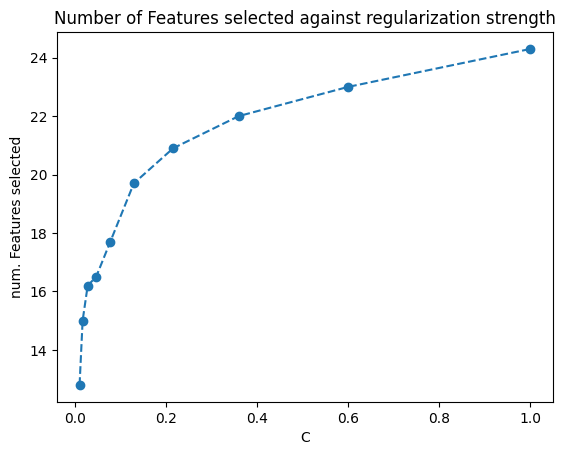

In [28]:
plt.close()
plt.figure()
plt.plot(C_values,np.mean(numFeatSelected,0),marker='o', linestyle='--')
plt.xlabel('C')
plt.ylabel('num. Features selected')
plt.title('Number of Features selected against regularization strength')
plt.show()

As we expect, the number of features selected decreases as we increase the regularization (C is the inverse of the regularization strength - smaller values specify stronger regularization). **Note:** You can also reverse it and call lambda if it will be less confusing and aligned with the literature.

Let us now plot the average OOB error against reg. strength.

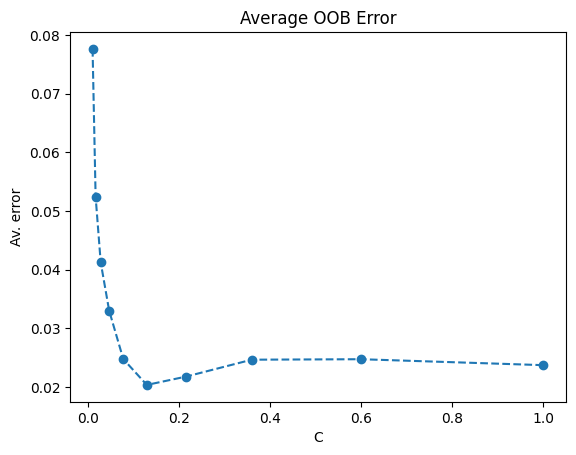

In [29]:
plt.close()
plt.figure()
plt.plot(C_values,np.mean(errors,0),marker='o', linestyle='--')
plt.xlabel('C')
plt.ylabel('Av. error')
plt.title('Average OOB Error')
plt.show()

Finally, let's use the stability measure, calculate the confidence intervals and plot it against the regularization strength.

In [31]:
for k in range(num_values):
    res=st.confidenceIntervals(Z[k,:,:],alpha=0.05) ## we get the confidence intervals using the stability package
    stabilities[k]=res['stability']
    errStab[k]=stabilities[k]-res['lower']

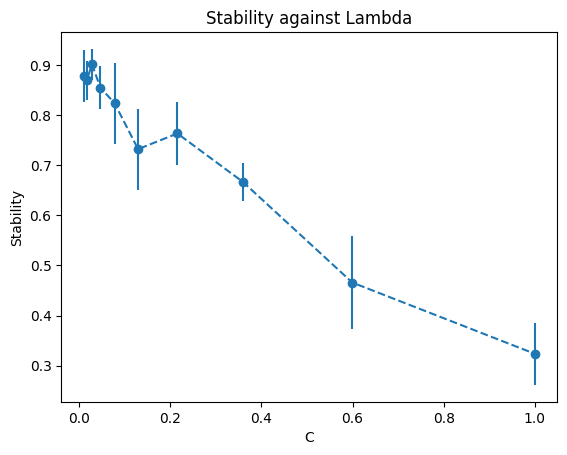

In [33]:
plt.close()
plt.figure()
plt.errorbar(C_values,stabilities,yerr=errStab,marker='o', linestyle='--')
plt.xlabel('C')
plt.ylabel('Stability')
plt.title('Stability against Lambda')
plt.show()

In [38]:
best_stability_index = np.nanargmax(stabilities)
gridsearch_index = np.where(C_values == gridsearch_classifier.best_params_['C'])[0][0]

print(f"--- C value that maximizes stability only = {C_values[best_stability_index]} ---")
print(f'Stability is maximal = {round(stabilities[best_stability_index]*100,2)}%. \nAverage Number of features selected for this lambda across {M} iterations is {np.mean(numFeatSelected[best_stability_index])}. \nAverage OOB error is {np.mean(errors[best_stability_index])}')
print('\n')
print(f"--- C value (chosen with grid search to maximize the accuracy only) = {gridsearch_classifier.best_params_['C']} ---")
print(f'Stability = {round(stabilities[gridsearch_index]*100,2)}%. \nAverage Number of features selected for this lambda across {M} iterations is {np.mean(numFeatSelected[gridsearch_index])}. \nAverage OOB error is {np.mean(errors[gridsearch_index])}')

--- C value that maximizes stability only = 0.027825594022071243 ---
Stability is maximal = 90.16%. 
Average Number of features selected for this lambda across 10 iterations is 20.1. 
Average OOB error is 0.0469387755102041


--- C value (chosen with grid search to maximize the accuracy only) = 0.5994842503189409 ---
Stability = 46.58%. 
Average Number of features selected for this lambda across 10 iterations is 17.2. 
Average OOB error is 0.031455399061032875


As we can see from these figures, the value of the regularizing parameter that yields the maximal stability (out of the 10 regularizing parameters chosen) is not the one yielding the minimum error. Here, a trade-off between error and stability needs to chosen.
Nevertheless, we can see that making a small sacrifcie in terms of accuracy can largely improve stability (OOB error of 0.03 vs. OOB of 0.04, but the stability of 47% vs. the stability of 90%).

### Feature occurrence as a measure of stability

If you ran your feature selection algorithm multiple times with different (bootstrapped) samples, you could additionally derive some other statistics as a measure for the robustnes of the algorithm with respect to feature selection. For example, for each feature, we can check how many times it was chosen across iterations.

We will showcase this for both of the C values - one chosen via grid search (maximizing accuracy) and one chosen as a trade-off between stability and accuracy. We will use the same matrix Z formed during the iterations.

In [40]:
feature_count_max_stability = Z_dict[C_values[best_stability_index]]
feature_count_max_accuracy = Z_dict[C_values[gridsearch_index]]

In [42]:
# As we saw, Z_dict stores dataframes with 1/0 values (chosen/not chosen) - we sum column-wise to get the count
chosen_per_feature_stability = pd.DataFrame(feature_count_max_stability.sum(axis=0)).reset_index()
chosen_per_feature_stability.columns = ['feature', 'count']
chosen_per_feature_stability.sort_values('count',inplace=True, ascending=False)
chosen_per_feature_stability

,feature,count
0,mean radius,10
26,worst concavity,10
21,worst texture,10
22,worst perimeter,10
1,mean texture,10
23,worst area,10
24,worst smoothness,10
20,worst radius,10
7,mean concave points,10
6,mean concavity,10


<Axes: title={'center': 'Number of times a feature was chosen across iterations.\nC value (reg.strength) chosen with maximal stability'}, ylabel='feature'>

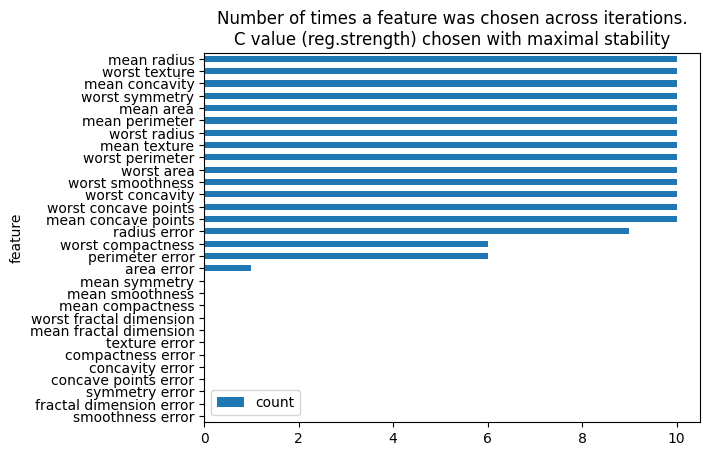

In [52]:
chosen_per_feature_stability = pd.DataFrame(feature_count_max_stability.sum(axis=0)).reset_index()
chosen_per_feature_stability.columns = ['feature', 'count']
chosen_per_feature_stability.sort_values('count',inplace=True, ascending=True)
# FOr BC dataset, plot all features as there are not that many
chosen_per_feature_stability.plot.barh(y='count', x='feature', title='Number of times a feature was chosen across iterations.\nC value (reg.strength) chosen with maximal stability')

# Plotting first N if there are a lot of features (e.g. tomato)
# N_features_to_plot = 50
#chosen_per_feature_stability.iloc[:N_features_to_plot,].plot.barh(y='count', x='feature', title='Number of times a feature was chosen across iterations.\nC value (reg.strength) chosen with maximal stability')


In [55]:
chosen_per_feature_stability['count'].value_counts()

10    14
0     12
6      2
1      1
9      1
Name: count, dtype: int64

--> 14 features were chosen all the time, 12 were not chosen at all across all the iterations.

Now, we do the same with the features chosen based on maximum accuracy:

<Axes: title={'center': 'Number of times a feature was chosen across iterations.\nC value (reg.strength) chosen with maximal accuracy'}, ylabel='feature'>

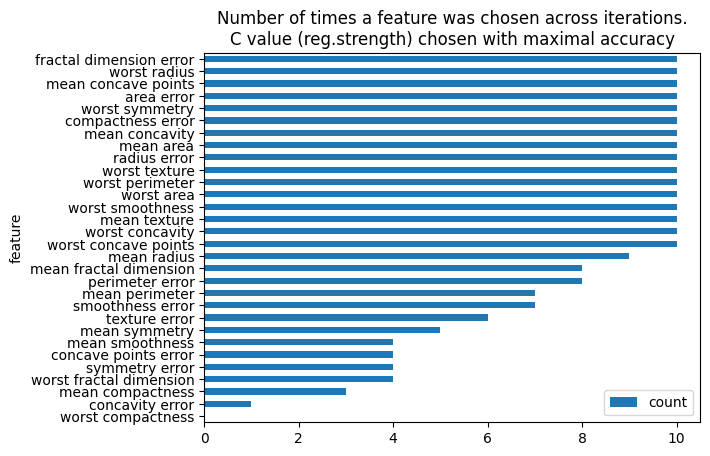

In [53]:
chosen_per_feature_accuracy = pd.DataFrame(feature_count_max_accuracy.sum(axis=0)).reset_index()
chosen_per_feature_accuracy.columns = ['feature', 'count']
chosen_per_feature_accuracy.sort_values('count',inplace=True, ascending=True)
# FOr BC dataset, plot all features as there are not that many
chosen_per_feature_accuracy.plot.barh(y='count', x='feature', title='Number of times a feature was chosen across iterations.\nC value (reg.strength) chosen with maximal accuracy')

# Plotting first N if there are a lot of features (e.g. tomato)
# N_features_to_plot = 50
#chosen_per_feature_stability.iloc[:N_features_to_plot,].plot.barh(y='count', x='feature', title='Number of times a feature was chosen across iterations.\nC value (reg.strength) chosen with maximal accuracy')


In [58]:
chosen_per_feature_accuracy['count'].value_counts()

10    16
4      4
7      2
8      2
0      1
1      1
3      1
5      1
6      1
9      1
Name: count, dtype: int64

--> 16 features were chosen all the time, 1 was not chosen at all across all the iterations.

**Note**: BC is a toy dataset, so it is 'more perfect'. However, for the tomato, what happend was that for the C value with max accuracy we don't even have a single feature that was chosen across all iterations whereas for the lambda with max stability we have much more(could be due to collinearity, though!) --> check if you have such 'story' for a dataset you choose. 

## Potential next steps

Now that we analysed which hyperparameter(s) might be good for fitting our model and what is the effect of it on the stability, we can choose how to proceed with the analysis. This, of course, depends on our goal and we will cover two possible options:

1. You wish to have a trained model with C_value of your choice that you want to reuse on the unseen data and use this to interpret the importance and selection of each feature.
2. You wish to decide on the final reduced set of features that will enter some other statistical analysis based on the analysis you already did with bootstrapping (e.g. the set of chosen genes will be selected for further inspection to seach for clinical signal or a doctor should pay extra attention to selected variables when assessing the patient.)

### Option 1 - training the model by using newly gained knowledge

Now that we know much more about the effect of the regularization parameter on both accuracy and stability of the model and feature selection, we need to decide whether we are ready to accept the aforementioned trade-off between accuracy and stability, i.e., decide if we want to lose a bit of accuracy for the sake of more stable model.

**TBD** - The idea here was to train the model with the C value which represents a trade-off between the stability and accuracy (so in the example above - taking the one that was maximising stability but not losing a lot of accuracy).

In [115]:
# No need to do that for showcasing, I guess CV is enough. But you choose how deep you want to go
# Maybe you wish to split only train/test and check the performance there.

# # Train test split
# X_train, X_test, y_train, y_test = train_test_split(
#     data_model.drop(columns=[target], axis=1),
#     data_model[target], stratify = data_model[target],
#     test_size=0.2,
#     random_state=444)

# # Train - validation split
# X_train, X_valid, y_train, y_valid = train_test_split(
#     X_train,
#     y_train, stratify = y_train,
#     test_size=0.2,
#     random_state=234)

# print(f"X train: {X_train.shape}, X test: {X_test.shape}, X valid: {X_valid.shape}")
# print(f"y train: {y_train.shape}, y test: {y_test.shape}, y valid: {y_valid.shape}")
# print(f"y train values: {np.unique(y_train, return_counts=True)}")
# print(f"y test values: {np.unique(y_test, return_counts=True)}")

# # Encode labels --> no need for BC dataset
# encoder = LabelEncoder()
# y_train = encoder.fit_transform(y_train)
# y_test = encoder.transform(y_test)
# print("Encoding check:")
# print(np.unique(y_train, return_counts=True))
# print(np.unique(y_test, return_counts=True))

# # Scale the data
# scaler = StandardScaler()
# X_train_transformed = scaler.fit_transform(X_train)
# X_test_transformed = scaler.transform(X_test)
# X_valid_transformed = scaler.transform(X_valid)


In [78]:
# Define a model
model = LogisticRegression(penalty = 'elasticnet', 
                           solver = 'saga', 
                           l1_ratio = 0.5, 
                           C = C_values[best_stability_index], 
                           max_iter=1000, 
                           random_state=12345)

model_grid = LogisticRegression(penalty = 'elasticnet', 
                                solver = 'saga', 
                                l1_ratio = 0.5, 
                                C = C_values[gridsearch_index],
                                max_iter=1000, 
                                random_state=12345)

In [82]:
oob_scorer = lambda y_test, y_pred: 1-accuracy_score(y_test, y_pred)
my_scorer = make_scorer(oob_scorer, greater_is_better=False) # Smaller OOB error means better model

# Run cross_val_score
print(f"Average accuracy across 4-fold cv: {round(np.mean(cross_val_score(model, X_transformed, y, cv=5, scoring='accuracy'))*100,2)}%")

Average accuracy across 4-fold cv: 95.43%


What if we fit with the grid-search index?

In [83]:
oob_scorer = lambda y_test, y_pred: 1-accuracy_score(y_test, y_pred)
my_scorer = make_scorer(oob_scorer, greater_is_better=False) # Smaller OOB error means better model

# Run cross_val_score
print(f"Average accuracy across 4-fold cv: {round(np.mean(cross_val_score(model_grid, X_transformed, y, cv=5, scoring='accuracy'))*100,2)}%")


Average accuracy across 4-fold cv: 97.54%


BC dataset: Losing around 2 percentage points of accuracy - a practicioner has to decide if this is worth - in biology it often is if you get the more stable feature sets!

Let's say we decide to take the model maximising the stability, with small sacrifice of accuracy. We will use this model to check which features are chosen:

In [103]:
model.fit(X_transformed, y)
coefficients = pd.DataFrame(model.coef_, columns=X.columns).T
coefficients.columns = ['coefficient']
coefficients['coefficient_abs'] = abs(coefficients['coefficient'])
coefficients.sort_values('coefficient_abs', inplace=True, ascending=False)
coefficients

,coefficient,coefficient_abs
worst concave points,-0.491020,0.491020
worst radius,-0.409737,0.409737
worst perimeter,-0.377799,0.377799
mean concave points,-0.356994,0.356994
worst texture,-0.309279,0.309279
worst area,-0.245374,0.245374
mean perimeter,-0.210326,0.210326
mean radius,-0.206937,0.206937
worst smoothness,-0.183093,0.183093
worst concavity,-0.166488,0.166488


After inspection of both stability and accuracy, we made a decision to sacrifice accuracy a bit to get more stable feature sets that might be relevant for clinical practice. We can now chose this model and use above coefficients to interpret the importance of each feature and also fit the model to the unseen dataset.

In [108]:
# # If you run this, you will see you get more features chosen. So, the above method yielded smaller feature set, but showing more stability across iterations. 

# model_grid.fit(X_transformed, y)
# coefficients = pd.DataFrame(model_grid.coef_, columns=X.columns).T
# coefficients.columns = ['coefficient']
# coefficients['coefficient_abs'] = abs(coefficients['coefficient'])
# coefficients.sort_values('coefficient_abs', inplace=True, ascending=False)
# coefficients

### Option 2 - selecting final set of features

Stability selector paper that is referenced in the Noguera paper (see Noguera paper Page 26 - 6.2.) defines the set of stable features as follows:

**set of stable features** = set of all the features having a frequency of selection higher than some user defined threshold for __at least__ one of the regularizing parameteres lambda from lambdas

Other options:\
..for chosen lambda, select the treshold and take the features above it \
..maybe find a consensus for C values with stability in a certain range?


**TBD** - decide if and how to proceed.

In [113]:
for i in range(len(C_values)):
    Z_i = Z_dict[C_values[i]]
    if i==0:
        count_per_feature = pd.DataFrame(Z_i.sum(axis=0), columns=['C_value_'+str(i)])
    else:
        count_per_feature = pd.concat([count_per_feature, pd.DataFrame(Z_i.sum(axis=0), columns=['C_value_'+str(i+1)])], axis=1)
count_per_feature['total'] = count_per_feature.sum(axis=1)
count_per_feature.sort_values(by='total', ascending=False, inplace=True)

In [114]:
count_per_feature

,C_value_0,C_value_2,C_value_3,C_value_4,C_value_5,C_value_6,C_value_7,C_value_8,C_value_9,C_value_10,total
worst radius,10,10,10,10,10,10,10,10,10,10,100
mean concave points,10,10,10,10,10,10,10,10,10,10,100
worst perimeter,10,10,10,10,10,10,10,10,10,10,100
worst area,10,10,10,10,10,10,10,10,10,10,100
worst concave points,10,10,10,10,10,10,10,10,10,10,100
worst concavity,10,10,10,10,10,10,10,10,10,10,100
worst texture,9,10,10,10,10,10,10,10,10,10,99
worst smoothness,8,10,10,10,10,10,10,10,10,10,98
mean concavity,10,10,10,10,9,9,10,10,10,10,98
mean area,10,10,10,10,10,10,10,10,10,8,98


In [119]:
# Set the threshold - percentage of M (number of bootstrapped samples)
threshold = int(1*M) # Let's say we want to be strict and take only features appearing 100% of the time - might not happen in the real word DS :)
threshold

10

In [120]:
final_feature_set = []
for i in range(count_per_feature.shape[0]):
    if (count_per_feature.iloc[i,:count_per_feature.shape[1]-1] >= threshold).any() == True:
        final_feature_set.append(count_per_feature.index[i])

In [121]:
#final_feature_set = list(count_per_feature.index[np.where(count_per_feature['total'] >= threshold)[0]])
print(f"There are {len(final_feature_set)} features in the final feature set, based on a threshold of {threshold}:\n")
print(*final_feature_set, sep='\n')

There are 18 features in the final feature set, based on a threshold of 10:

worst radius
mean concave points
worst perimeter
worst area
worst concave points
worst concavity
worst texture
worst smoothness
mean concavity
mean area
mean radius
mean perimeter
worst symmetry
mean texture
radius error
area error
fractal dimension error
compactness error


**TBD** -  Do we even go here? Maybe having trained model is sufficient for most people. There are plenty of questions one has to decide in this approach (how to choose the threshold, do we look at all C values as we did or only the chosen one, what about overfitting and correlations)...Might be confusing for the tutorial!